In [122]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, fbeta_score
# from sklearn.naive_bayes import BernoulliNB
from tabulate import tabulate
import os

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import shutil
# from joblib import dump, load
import pickle
import jsonpickle
from datetime import datetime

%matplotlib inline 
%run ./vectorizer.ipynb

In [46]:
%run ./preprocess.ipynb

ds_root = '/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/'
r_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_random_sample_predicted.csv')
r_df = read_file(r_path)

m_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_v1_g.csv')
m_df = read_file(m_path)

raw_df = pd.concat([r_df, m_df])
raw_df.reset_index(drop=True, inplace=True)
options = {
    'handle_unicode': True,
    'handle_emoji': True,
    'handle_email': True,
    'handle_username': True,
    'handle_hashtags': True,
    'handle_url': True,
    'handle_markup': True,
    'handle_retweet': True,
    'handle_case': True,
    'handle_lemmatization': True,
    'handle_stopwords': True,
    'handle_punctuation': True,
    'handle_contractions': True,
    'print_stats': True
}
df = process_data(raw_df, **options)

# replace placeholders.
df.text = df.text.str.replace('HASHTAG', '', )
df.text = df.text.str.replace('HANDLE', '')
df.text = df.text.str.replace('URL', '')
df.text = df.text.str.replace('rt', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gaurav.gupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


------------------  -----------  ------------
Step                Total words  Unique words
Start               77684        20305
Remove Retweet      66365        18473
Lower               66365        16581
Remove Retweet      66649        16532
Lemmatize           66649        15779
Unicode Fix         66656        15752
Replace emoji       67043        15848
Stop words          50235        15273
Email Replace       50235        15266
UserName replace    50921        14248
HashTags Replace    64615        10461
URL Replace         64615        8398
MARKUP Replace      64615        8397
Remove punctuation  64615        6668
------------------  -----------  ------------


In [47]:
def test_model(model):
    pred_test = model.predict(x_test)
    model_acc_score = accuracy_score(y_test, pred_test)
    model_f1_score = f1_score(y_test, pred_test)
    model_prec_score = precision_score(y_test, pred_test)
    model_recall_score = recall_score(y_test, pred_test)
    model_f2_score = fbeta_score(y_test, pred_test, beta=2)
    results = []
    results.append(('Metric',   'Score'))
    results.append(('Accuracy', model_acc_score*100))
    results.append(('F1 Score', model_f1_score*100))
    results.append(('F-Beta Score', model_f2_score*100))
    results.append(('Precision Score', model_prec_score*100))
    results.append(('Recall Score', model_recall_score*100))
    print(tabulate(results))
    return pred_test

(2421, 188)
---------------  -----------------
Metric           Score
Accuracy         94.49793672627234
F1 Score         81.81818181818181
F-Beta Score     84.58646616541354
Precision Score  77.58620689655173
Recall Score     86.53846153846155
---------------  -----------------


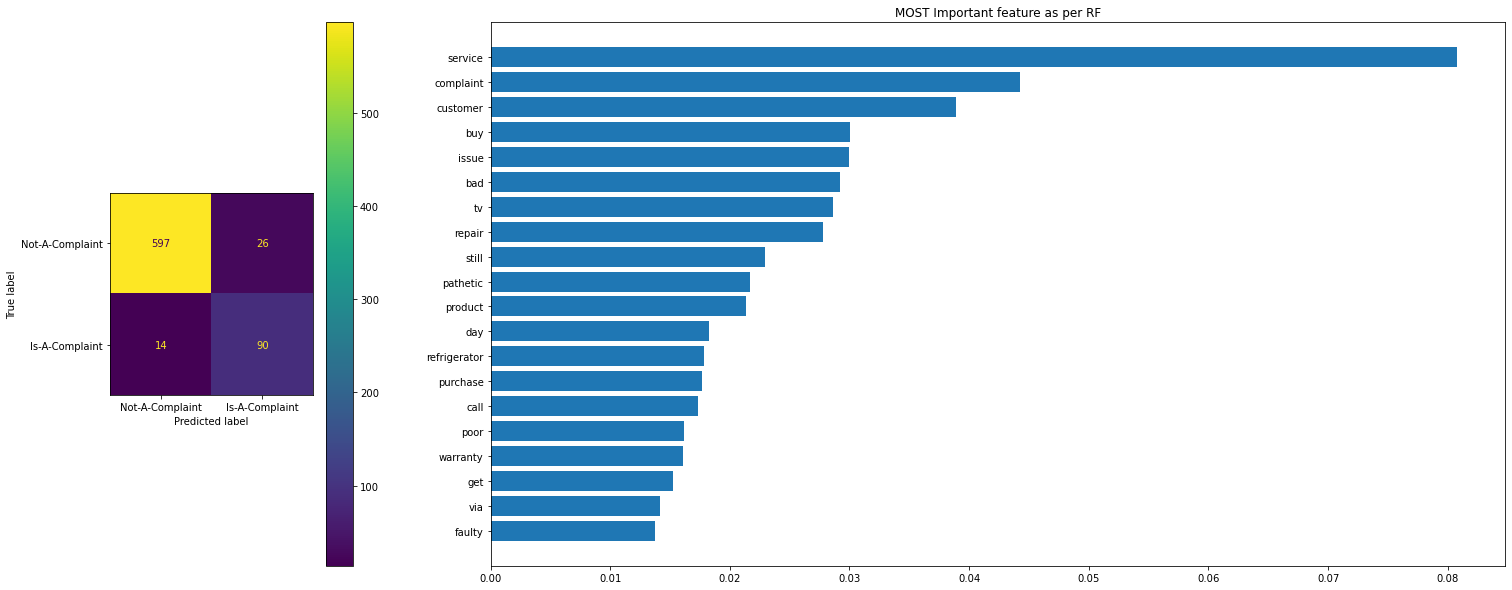

In [180]:
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer


def plot_important_features(clf, tfidf, axs):
    # Display Important feature
    n = 20
    f_imp = [list(i) for i in list(zip(clf.feature_importances_, tfidf.get_feature_names()))]
    f_imp_df = pd.DataFrame(f_imp, columns=['Importance', 'Feature'])
    top_n_features = f_imp_df.sort_values(by=['Importance'], ascending=False).head(n).sort_values(by=['Importance'])
    axs[1].barh(top_n_features['Feature'], top_n_features['Importance'])
    axs[1].set_title('MOST Important feature as per RF')
    return

labelEncoder = OrderedDict({ 'Not-A-Complaint': 0, 'Is-A-Complaint': 1, })
display_labels = list(labelEncoder.keys())
labels = list(labelEncoder.values())

# max_df: Ignore terms that occur in MORE THAN N% of document.  CORPUS-SPECIFIC-STOPWORDS.
# min_df: Ignore terms that occur in LESS THAN N% of document.


tfidf = TfidfVectorizer(lowercase=False, max_df=0.8, min_df=0.01, ngram_range=(1,1))  # Most of the terms are eliminated by min_df 
vectors = tfidf.fit_transform(df['text']).toarray()  # 2
print(vectors.shape)
# model_d2v = train_doc_model(df.text, vector_size=128)
# vectors = create_documents_vectors_from_Doc2Vec(df.text, model_d2v, vector_size=128)

x_train, x_test, y_train, y_test = train_test_split(vectors, df['Complaint'], random_state=42, test_size=0.30)  # 1

# clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=210, max_features=11, criterion='gini', oob_score=True, class_weight='balanced')
clf = RandomForestClassifier(max_depth=12, random_state=0, n_estimators=165, max_features=4, criterion='gini', oob_score=True, class_weight='balanced')
clf.fit(x_train, y_train)
pred_test = test_model(clf)

fig, axs = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 4]})
plot_confusion_matrix(clf, x_test, y_test, labels=labels, display_labels=display_labels, ax=axs[0])
plot_important_features(clf, tfidf, axs)
plt.show()


In [166]:
root = '/home/gaurav.gupta/projects/PoCs/brandMention/brand_ml'

def get_model_info(model, model_name):
    info = {
        'name': str(model.__class__),
        model_name: model.get_params()
    }
    return info

def get_experiment_info(model_dict, tags):
    experiment_info = {
        'models_info': [get_model_info(model_dict[m], m) for m in model_dict.keys()],
        'tags': tags,
        'timestamp': datetime.now().isoformat()}
    return experiment_info

def save_experiment(experiment_name, model_dict, tags, results={}, preprocess_details={}):
    folder = os.path.join(root, 'experiments', experiment_name)
    # models = list(model_dict.values())
    model_names = model_dict.keys()
    readme_file_path = os.path.join(folder, 'artifacts.json')
    results_fp = os.path.join(folder, 'results.csv')

    experiment_info = get_experiment_info(model_dict, tags)
    experiment_info['name'] = experiment_name
    experiment_info['results'] = results
    experiment_info['preprocess_config'] = preprocess_details

    # Write models.
    os.makedirs(folder)
    [pickle.dump(model_dict[name], open(os.path.join(folder, f'{name}.pickle'), 'wb')) for name in model_names]
    
    frozen = jsonpickle.encode(experiment_info, indent=4)
    with open(readme_file_path, "w") as outfile:
        outfile.write(frozen)
    return

def load_model(experiment_name):
    # pickle.dump(tfidf, open("./models/tfidf_rf_f1_9371.pickle", "wb"))
    # dump(clf, './models/rf_f1_9371.joblib')
    experiment_path = f"{root}/experiments/{experiment_name}"
    vectorizer = pickle.load(open(f"{experiment_path}/vectorizer.pickle", "rb"))
    clf = pickle.load(open(f"{experiment_path}/classifier.pickle", 'rb'))
    model_dict = { 'classifier': clf, 'vectorizer': vectorizer }
    return model_dict

model_dict = OrderedDict({ 'classifier': clf, 'vectorizer': tfidf })
experiment_name = "RF_FBeta_Unigram_8458_Jan03"
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
experiment_results = {
    "tn": float(tn), "fp": float(fp), "fn": float(fn), "tp": float(tp),
    "model_acc_score" : float(accuracy_score(y_test, pred_test)),
    "model_f1_score" : float(f1_score(y_test, pred_test)),
    "model_prec_score": float(precision_score(y_test, pred_test)),
    "model_recall_score": float(recall_score(y_test, pred_test)),
    "model_f2_score": float(fbeta_score(y_test, pred_test, beta=2)),
}

notes = { 'details': ['Uni Model', 'Remove Excessive Spaces', 'Handle contractions'] }

# SAVE THE EXPERIMENT ARTIFACTS
shutil.rmtree(os.path.join(root, 'experiments', experiment_name), ignore_errors=True)
save_experiment(experiment_name, model_dict, tags=notes, results=experiment_results, preprocess_details=options)


# LOAD THE EXPERIMENT ARTIFACTS
# model_dict = load_model(experiment_name)
# sample_vector = model_dict['vectorizer'].transform(['This raise complaint'])
# sample_predic = model_dict['classifier'].predict(sample_vector)
# sample_predic

In [169]:

def prediction_service(sample_text, vectorizer=tfidf, clf=clf):
   sample_df = pd.DataFrame(data={'text': sample_text})
   sample_df = process_data(sample_df, **options)
   sample_df.text = sample_df.text.str.replace('HASHTAG', '', )
   sample_df.text = sample_df.text.str.replace('HANDLE', '')
   sample_df.text = sample_df.text.str.replace('URL', '')
   sample_df.text = sample_df.text.str.replace('rt', '')
   sample_vector = vectorizer.transform(sample_df['text'])
   ans = clf.predict(sample_vector)
   probs = clf.predict_proba(sample_vector)
   prob_of_being_complaint = probs[:,1:2]
   sample_df['Prediction'] = ans
   sample_df['Predict_Probab'] = prob_of_being_complaint
   return sample_df

sample_text = [
            'This is such a poor product. It didnot worked for even 1 day',
            "#panasonicindia I tweeted again and again but still my complaint is not resolve",
            "@PanasonicIndia I've a 32 LCD/LED tv Model No. TH-W32ES48DX in which I'm having an issue to see Netflix under the Market Apps section. How do I fix this?",
            "Disposed my laptop successfully with the help of @PanasonicIndia #DiwaliwaliSafai #PanasonicIndia Join @chidambar08 @dayalojha_ @AswaniJaishree",
            "Panasonic's Akhil Sethi joins Harman India as digital marketing head #HarmanIndia #Panasonic #AkhilSethi #Vivo #Isobar #Devices #PanasonicIndia",
         ]

results = prediction_service(sample_text)
print(results.loc[2][0])
results


------------------  -----------  ------------
Step                Total words  Unique words
Start               86           78
Remove Retweet      86           78
Lower               86           77
Remove Retweet      88           78
Lemmatize           88           74
Unicode Fix         88           74
Replace emoji       88           74
Stop words          56           51
Email Replace       56           51
UserName replace    57           49
HashTags Replace    67           42
URL Replace         67           42
MARKUP Replace      67           42
Remove punctuation  67           42
------------------  -----------  ------------
 I 32 lcdled tv model no thw32es48dx I issue see netflix market apps section fix this


,text,orig_text,Prediction,Predict_Probab
0,poor product didnot work even 1 day,This is such a poor product. It didnot worked ...,1,0.552242
1,tweet still complaint resolve,#panasonicindia I tweeted again and again but ...,1,0.556265
2,I 32 lcdled tv model no thw32es48dx I issue s...,@PanasonicIndia I've a 32 LCD/LED tv Model No....,1,0.541833
3,disposed laptop successfully help join,Disposed my laptop successfully with the help ...,0,0.283466
4,panasonics akhil sethi join harman india digit...,Panasonic's Akhil Sethi joins Harman India as ...,0,0.292838


In [118]:
import numpy as np


def tfidf_to_text(vectors):
    list_of_tokens = tfidf.inverse_transform(vectors)
    return list(map(lambda tokens: ' '.join(tokens), list_of_tokens))

def get_master_result(A=y_test, B=pred_test):
    C = np.logical_xor(A, B)
    results = pd.DataFrame(data={'Actual': A, 'Predicted': B,
                        'Status': ~C, 'tfidf_text': tfidf_to_text(x_test)})
    return results

In [119]:
# False Negative: Actually True but predicted Negative
results = get_master_result(y_test, pred_test)
FN = results[(results['Status'] == False) & (results['Actual'] == 1)]
master_FN = FN.join(df.iloc[FN.index], how='left')
print('Total FN: {}\tTotal joined rows: {}'.format(FN.shape, master_FN.shape))
master_FN.head(5)[['orig_text', 'text', 'tfidf_text', 'Actual', 'Predicted']]
# master_FN.to_csv('./fn.csv', header=True)

IndexError: positional indexers are out-of-bounds

In [121]:
# False positive: Actually False but predicted True
results = get_master_result(y_test, pred_test)
FP = results[(results['Status'] == False) & (results['Actual'] == 0)]
master_FP = FP.join(df.iloc[FP.index], how='left')
# print('Total FP: {}\tTotal joined rows: {}'.format(FN.shape, master_FP.shape))
# master_FP.to_csv('./fp.csv', header=True)
master_FP.head(5)

IndexError: positional indexers are out-of-bounds